# Pool Ball Prediction

# 1st Level Classification

This notebook provides the 1st level classification of our project. ie, detecting pool ball into Solid or stripe 

# Dependencies

In [392]:
#depedencies
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Activation,MaxPooling2D,Dropout
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.layers import GuassianNoise
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

# Import Dataset

In [393]:
#Loading folders from Local System  
ImageFolders=[]
ImageFolders = os.listdir("D:/USF CourseWork/ISM 6251 DSP/FinalProject")
ImageFolders
#We have 14 folders 

['Black_Solid_8',
 'Blue_Solid_2',
 'Blue_Stripe_12',
 'Brown_Solid_7',
 'Brown_Stripe_15',
 'Green_Solid_6',
 'Green_Stripe_14',
 'Orange_Solid_5',
 'Orange_Stripe_13',
 'Purple_Solid_4',
 'Red_Solid_3',
 'Red_Stripe_11',
 'Yellow_Solid_1',
 'Yellow_Stripe_9']

In [394]:
#Loading Image Names from all the folders into databrae
Total_data = []
ImageFile = [0] * len(ImageFolders)
length = 0
for i in range(0,len(ImageFolders)):
    ImageFile[i] = os.listdir("D:/USF CourseWork/ISM 6251 DSP/FinalProject" + "/" + str(ImageFolders[i]))
    length = length + len(ImageFile[i])    
#ImageFile


In [395]:
#loading images as numpy array into Jupyter notebook into a list
ImageFiles = []
for j in range(0, len(ImageFolders)):
    for k in range(0,len(ImageFile[j])):
        Img=np.array(Image.open("D:/USF CourseWork/ISM 6251 DSP/FinalProject" + "/" + str(ImageFolders[j])+ "/" + str(ImageFile[j][k])).resize((160,120)))
        Total_data.append([Img, ImageFolders[j]])

# Preprocessing

In [396]:
# Converting Image list into pandas dataframe
ImageDF = pd.DataFrame(Total_data)
ImageDF=ImageDF.rename(columns={0: 'Images',1:'Labels'}) #rename pandas dataframe column names
ImageDF.head(2)

,Images,Labels
0,"[[[158, 103, 49], [158, 103, 47], [159, 104, 4...",Black_Solid_8
1,"[[[157, 105, 53], [159, 108, 55], [162, 112, 5...",Black_Solid_8


In [397]:
#Since loading images take lots of time, lets make a backup copy of the image files
ImageDF1=ImageDF.copy()

In [398]:
#Split label column into Colour type and Number 
ImageDF1[['Color','Type','Number']] = ImageDF1.Labels.str.split("_",expand=True)
ImageDF1.head(3)

,Images,Labels,Color,Type,Number
0,"[[[158, 103, 49], [158, 103, 47], [159, 104, 4...",Black_Solid_8,Black,Solid,8
1,"[[[157, 105, 53], [159, 108, 55], [162, 112, 5...",Black_Solid_8,Black,Solid,8
2,"[[[163, 114, 36], [164, 115, 43], [161, 113, 4...",Black_Solid_8,Black,Solid,8


In [399]:
#Type dataframe for 1st level classsification, colour dataframe for 2nd level classsification
ImageDF_Type = ImageDF1[['Images','Type']]
ImageDF_Color = ImageDF1[['Images','Color','Type']]
ImageDF_Type.head(3)

,Images,Type
0,"[[[158, 103, 49], [158, 103, 47], [159, 104, 4...",Solid
1,"[[[157, 105, 53], [159, 108, 55], [162, 112, 5...",Solid
2,"[[[163, 114, 36], [164, 115, 43], [161, 113, 4...",Solid


In [714]:
#Creating Test Set by startified split test size "20%"

split = StratifiedShuffleSplit(n_splits=5,test_size = 0.2,random_state = 42)
print(split)
for train_index,test_index in split.split(ImageDF_Type,ImageDF_Type["Type"]):
    train_set = ImageDF_Type.iloc[train_index]
    test_set = ImageDF_Type.iloc[test_index]


StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None)


In [715]:
##Creating Validation Set by startified split test size "20%"

X_train,X_val,y_train,y_val = train_test_split(train_set["Images"],train_set["Type"],test_size=0.2,random_state=42)
print(X_train.shape,X_val.shape,y_val.shape,y_val.shape)

(1401,) (351,) (351,) (351,)


In [716]:
#Converting Labels into binary Categorical variables.
#y_train = pd.factorize(y_train)
y_train_new=[0]*len(y_train)
for i in range (0,len(y_train)):
    if y_train.iloc[i] == 'Stripe':
        y_train_new[i]=[1];
    elif y_train.iloc[i] == 'Solid':
        y_train_new[i]=[0];

In [717]:
#converting labels of train into numpy array for model
y_train_new_array=np.array(y_train_new)

In [718]:
#Similarly to Validation set
y_val_new=[0]*len(y_val)
for i in range (0,len(y_val)):
    if y_val.iloc[i] == 'Stripe':
        y_val_new[i]=[1];
    elif y_val.iloc[i] == 'Solid':
        y_val_new[i]=[0]
y_val_new_array=np.array(y_val_new)

In [719]:
y_val_new_array=np.array(y_val_new)

In [720]:
#converting each 3d image in a list into 4D tensor array as we need for input to CNN
X_train_new =[0] * len(X_train) 
for i in range(0,len(X_train)):
    X_train_new[i] = np.reshape((X_train.iloc[i]),(120,160,3))

X_train_array = np.asarray(X_train_new)

X_val_new=[0] * len(X_val)
for i in range(0,len(X_val)):
    X_val_new[i] = np.reshape((X_val.iloc[i]),(120,160,3))
    
X_val_array = np.asarray(X_val_new)

# Modelling

In [721]:
#model defining for CNN 1st level
from keras.layers import GaussianNoise
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train_array.shape[1:]))
model.add(GaussianNoise(0.1))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(GaussianNoise(0.1))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

In [722]:
# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

In [723]:
# Let's train the model using RMSprop
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy',patience=5, verbose=1, mode='max')

In [724]:
#normalising image 
X_train_array = X_train_array.astype('float32')
X_val_array = X_val_array.astype('float32')
X_train_array /= 255
X_val_array /= 255

In [660]:
#fitting model
Model1=model.fit(X_train_array, y_train_new_array,
              batch_size=32,
              epochs=10,
              validation_data=(X_val_array, y_val_new_array),
              shuffle=True,callbacks=[es])

Train on 1401 samples, validate on 351 samples
Epoch 1/10
1401/1401 [==============================] - 127s 91ms/step - loss: 1.1027 - accuracy: 0.5739 - val_loss: 0.6512 - val_accuracy: 0.6068
Epoch 2/10
1401/1401 [==============================] - 127s 90ms/step - loss: 0.6228 - accuracy: 0.6481 - val_loss: 0.5582 - val_accuracy: 0.6895
Epoch 3/10
1401/1401 [==============================] - 128s 91ms/step - loss: 0.4558 - accuracy: 0.7687 - val_loss: 0.5197 - val_accuracy: 0.6895
Epoch 4/10
1401/1401 [==============================] - 127s 91ms/step - loss: 0.3529 - accuracy: 0.8301 - val_loss: 0.4329 - val_accuracy: 0.7578
Epoch 5/10
1401/1401 [==============================] - 127s 91ms/step - loss: 0.2812 - accuracy: 0.8580 - val_loss: 0.4779 - val_accuracy: 0.7692
Epoch 6/10
1401/1401 [==============================] - 125s 89ms/step - loss: 0.2212 - accuracy: 0.8979 - val_loss: 0.2464 - val_accuracy: 0.8889
Epoch 7/10
1401/1401 [==============================] - 127s 91ms/step 

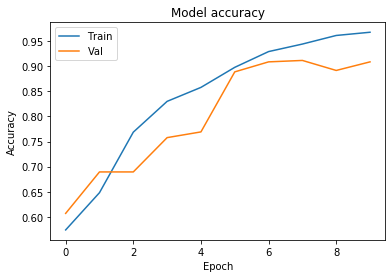

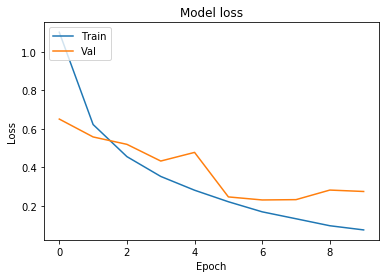

In [711]:
#Learning curves
plt.plot(Model1.history['accuracy'])
plt.plot(Model1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(Model1.history['loss'])
plt.plot(Model1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### From the above Learning Curve we can see that with increase in epochs the model accuracy has increased and loss has decreased. Our test and Validation accuracy of the model are  0.96  and 0.90 respectively.

# model evaluation on test set

In [585]:
X_test_set=test_set["Images"]
Y_test_set=test_set["Type"]

In [586]:
Y_test_set_list=[0]*len(Y_test_set)
for i in range (0,len(Y_test_set)):
    if Y_test_set.iloc[i] == 'Stripe':
        Y_test_set_list[i]=[1];
    elif Y_test_set.iloc[i] == 'Solid':
        Y_test_set_list[i]=[0];
Y_test_set_array=np.array(Y_test_set_list)

In [587]:
X_test_set_list =[0] * len(X_test_set) 
for i in range(0,len(X_test_set)):
    X_test_set_list[i] = np.reshape((X_test_set.iloc[i]),(120,160,3))

X_test_set_array = np.asarray(X_test_set_list)

X_test_set_array = X_test_set_array.astype('float32')
X_test_set_array /= 255

In [588]:
#Evaluating model
scores = model.evaluate(X_test_set_array, Y_test_set_array, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

439/439 [==============================] - 6s 13ms/step
Test loss: 0.09597241651937195
Test accuracy: 0.9567198157310486


Our model has tried to achieve 95% test accuracy

In [589]:
predictions=model.predict_classes(X_test_set_array)

In [590]:
#Confusion matrix
confusion_matrix(Y_test_set_array, predictions)

array([[270,   0],
       [ 19, 150]], dtype=int64)

In [591]:
#Precision and recall
print('Precision score of 1st level classifier:%.2f'%precision_score(Y_test_set_array, predictions))
print('Recall score of 1st level classifier:%.2f'%recall_score(Y_test_set_array, predictions))

Precision score of 1st level classifier:1.00
Recall score of 1st level classifier:0.89


In [592]:
print('F1 score of first MLP classifier:%.2f'%f1_score(y_test_new2_array, predictions))

F1 score of first MLP classifier:0.94


Our model's F1 score is 0.94 and it is on par with the accuracy

# With data generator

In [725]:
from keras.preprocessing.image import ImageDataGenerator

In [726]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.3,  
        zoom_range=0.3,  
        channel_shift_range=0.2,  
        fill_mode='nearest',
        cval=0.2,  
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.2)
datagen.fit(X_train_array)
Model2=model.fit_generator(datagen.flow(X_train_array, y_train_new_array,
                                     batch_size=32),
                        epochs=20,
                        validation_data=(X_val_array, y_val_new_array),
                        workers=4)

Epoch 1/20
44/44 [==============================] - 90s 2s/step - loss: 1.1792 - accuracy: 0.5460 - val_loss: 0.6867 - val_accuracy: 0.6068
Epoch 2/20
44/44 [==============================] - 94s 2s/step - loss: 0.6885 - accuracy: 0.5882 - val_loss: 0.6803 - val_accuracy: 0.6068
Epoch 3/20
44/44 [==============================] - 94s 2s/step - loss: 0.6728 - accuracy: 0.6146 - val_loss: 0.6766 - val_accuracy: 0.6068
Epoch 4/20
44/44 [==============================] - 95s 2s/step - loss: 0.6618 - accuracy: 0.6196 - val_loss: 0.6737 - val_accuracy: 0.6068
Epoch 5/20
44/44 [==============================] - 94s 2s/step - loss: 0.6412 - accuracy: 0.6203 - val_loss: 0.6400 - val_accuracy: 0.6268
Epoch 6/20
44/44 [==============================] - 104s 2s/step - loss: 0.5922 - accuracy: 0.6902 - val_loss: 0.6203 - val_accuracy: 0.7151
Epoch 7/20
44/44 [==============================] - 98s 2s/step - loss: 0.5431 - accuracy: 0.7238 - val_loss: 0.5383 - val_accuracy: 0.7123
Epoch 8/20
44/44 [=

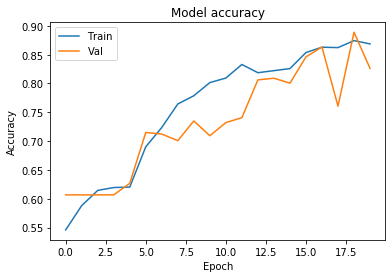

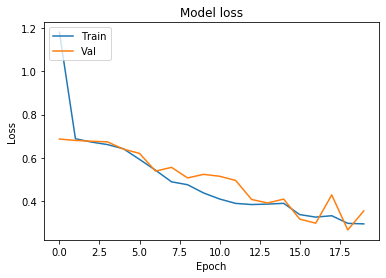

In [727]:
#Learning curves
plt.plot(Model2.history['accuracy'])
plt.plot(Model2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(Model2.history['loss'])
plt.plot(Model2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [728]:
scores = model.evaluate(X_test_set_array, Y_test_set_array, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

439/439 [==============================] - 4s 9ms/step
Test loss: 0.28581935123186175
Test accuracy: 0.8656036257743835


In [729]:
predictions=model.predict_classes(X_test_set_array)

In [730]:
#Confusion matrix
confusion_matrix(Y_test_set_array, predictions)

array([[220,  50],
       [  9, 160]], dtype=int64)

In [731]:
print('F1 score of first version of classifier:%.2f'%f1_score(y_test_new2_array, predictions))

F1 score of first version of classifier:0.84


F1 score has been decreased from 0.94 to 0.88. but model generalised more